In [ ]:
import pandas as pd

In [ ]:
# CalIt2 è un dataset relativo alla misurazione del numero di persone in 
# ingresso e uscita da un edificio. 
# Per i dettagli si rimanda alla pagina del dataset:
# https://archive.ics.uci.edu/ml/datasets/CalIt2+Building+People+Counts
calit2 = pd.read_csv("calit2.data", header=None)

# occupancy_change : indica il numero di ingressi/uscite
# direction: indica se il valore di occupancy_change è relativo
# ad un ingresso (direction = 9) oppure ad un'uscita (direction = 7)
calit2.columns = ["direction", "date", "time", "occupancy_change"]
calit2

,direction,date,time,occupancy_change
0,7,07/24/05,00:00:00,0
1,9,07/24/05,00:00:00,0
2,7,07/24/05,00:30:00,1
3,9,07/24/05,00:30:00,0
4,7,07/24/05,01:00:00,0
...,...,...,...,...
10075,9,11/05/05,22:30:00,0
10076,7,11/05/05,23:00:00,0
10077,9,11/05/05,23:00:00,0
10078,7,11/05/05,23:30:00,1


Per prima cosa, vogliamo eliminare la colonna *direction*, incorporandone
il contenuto informativo nella colonna *occupancy_change*. A tale scopo, si moltiplicano per -1 tutti i valori di *occupancy_change* 
relativi a un'uscita.

In [ ]:
calit2.loc[:, "occupancy_change"][calit2["direction"] == 7] *= -1
calit2.drop("direction", axis="columns", inplace=True)
calit2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,date,time,occupancy_change
0,07/24/05,00:00:00,0
1,07/24/05,00:00:00,0
2,07/24/05,00:30:00,-1
3,07/24/05,00:30:00,0
4,07/24/05,01:00:00,0
...,...,...,...
10075,11/05/05,22:30:00,0
10076,11/05/05,23:00:00,0
10077,11/05/05,23:00:00,0
10078,11/05/05,23:30:00,-1


Dopodiché modifichiamo la colonna date in modo da mettere le date nel 
formato YYYY-MM-DD, più adatto a Facebook Prophet. Notare che modifichiamo 
anche l'anno, per via di limitazioni di Adafruit IO (che non consente di caricare rilevazioni troppo indietro nel tempo).

In [ ]:
def date_to_yyyymmdd(date):
  month, day, year = date.split("/")
  return '2021' + '-' + month + '-' + day

In [ ]:
calit2['date'] = calit2.loc[:, 'date'].apply(date_to_yyyymmdd)
calit2

,date,time,occupancy_change
0,2021-07-24,00:00:00,0
1,2021-07-24,00:00:00,0
2,2021-07-24,00:30:00,-1
3,2021-07-24,00:30:00,0
4,2021-07-24,01:00:00,0
...,...,...,...
10075,2021-11-05,22:30:00,0
10076,2021-11-05,23:00:00,0
10077,2021-11-05,23:00:00,0
10078,2021-11-05,23:30:00,-1


Poi uniamo le colonne *date* e *time* in una nuova colonna *timestamp*.

In [ ]:
calit2["timestamp"] = calit2["date"] + " " + calit2["time"]
calit2.drop(["date", "time"], axis="columns", inplace=True)
calit2

,occupancy_change,timestamp
0,0,2021-07-24 00:00:00
1,0,2021-07-24 00:00:00
2,-1,2021-07-24 00:30:00
3,0,2021-07-24 00:30:00
4,0,2021-07-24 01:00:00
...,...,...
10075,0,2021-11-05 22:30:00
10076,0,2021-11-05 23:00:00
10077,0,2021-11-05 23:00:00
10078,-1,2021-11-05 23:30:00


Generiamo un nuovo dataframe con colonne *created_at* e *value*, ottenuto a 
partire da *calit2* sommando i valori di *occupancy_change* relativi allo
stesso *timestamp* (questo equivale a calcolare la variazione nel numero 
di persone nell'edificio rispetto al *timestamp* precedente).

In [ ]:
occupancy_dict = {
    "created_at": [],
    "value": []
}

for timestamp in calit2["timestamp"].unique():
  occupancy = calit2.loc[:, "occupancy_change"][calit2["timestamp"] == timestamp].sum()
  occupancy_dict["created_at"].append(timestamp)
  occupancy_dict["value"].append(occupancy)

occupancy_dataset = pd.DataFrame(occupancy_dict)
calit2 = None
occupancy_dict = None
occupancy_dataset

,created_at,value
0,2021-07-24 00:00:00,0
1,2021-07-24 00:30:00,-1
2,2021-07-24 01:00:00,0
3,2021-07-24 01:30:00,0
4,2021-07-24 02:00:00,0
...,...,...
5035,2021-11-05 21:30:00,0
5036,2021-11-05 22:00:00,-3
5037,2021-11-05 22:30:00,0
5038,2021-11-05 23:00:00,0


Andiamo a sostituire ogni valore della colonna *value* con la somma dei valori
relativi ai *timestamp* precedenti, di modo che ogni valore della colonna
risultante rappresenta il numero di persone nell'edificio in un
dato momento.

In [ ]:
occupancy_dataset["value"] = occupancy_dataset["value"].cumsum()
occupancy_dataset

,created_at,value
0,2021-07-24 00:00:00,0
1,2021-07-24 00:30:00,-1
2,2021-07-24 01:00:00,-1
3,2021-07-24 01:30:00,-1
4,2021-07-24 02:00:00,-1
...,...,...
5035,2021-11-05 21:30:00,764
5036,2021-11-05 22:00:00,761
5037,2021-11-05 22:30:00,761
5038,2021-11-05 23:00:00,761


In [ ]:
occupancy_dataset.describe()

,value
count,5040.000000
mean,494.647817
std,255.468692
min,-12.000000
25%,292.000000
50%,524.000000
75%,750.000000
max,854.000000


Poiché il numero minimo di persone nell'edificio è negativo, deduciamo che
l'edificio non dovesse essere vuoto in corrispondenza del primo *timestamp*: per evitare di avere valori di *value* negativi, cosa evidentemente insensata,
aggiungiamo -min ad ogni valore di value.

In [ ]:
occupancy_dataset.loc[:, 'value'] += 12
occupancy_dataset.describe()

,value
count,5040.000000
mean,506.647817
std,255.468692
min,0.000000
25%,304.000000
50%,536.000000
75%,762.000000
max,866.000000


Scaliamo la colonna value del dataset di un fattore 1/25, per avere misurazioni più gestibili in fase di test del funzionamento del sistema.

In [ ]:
occupancy_dataset.loc[:, 'value'] //= 25
occupancy_dataset.describe()

,value
count,5040.000000
mean,19.801587
std,10.228211
min,0.000000
25%,12.000000
50%,21.000000
75%,30.000000
max,34.000000


In [ ]:
occupancy_dataset.head(10)

,created_at,value
0,2021-07-24 00:00:00,0
1,2021-07-24 00:30:00,0
2,2021-07-24 01:00:00,0
3,2021-07-24 01:30:00,0
4,2021-07-24 02:00:00,0
5,2021-07-24 02:30:00,0
6,2021-07-24 03:00:00,0
7,2021-07-24 03:30:00,0
8,2021-07-24 04:00:00,0
9,2021-07-24 04:30:00,0


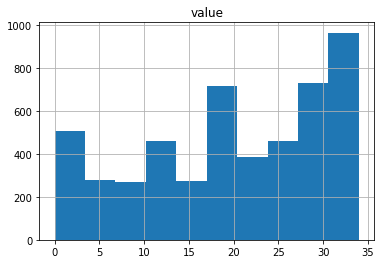

In [ ]:
occupancy_dataset.hist()
pass

Infine salviamo *occupancy_dataset* come file csv.

In [ ]:
feed = "location-1"
occupancy_dataset.to_csv(feed + ".csv", sep=";", index=False)